# Actions actually doing something or not

Training ID: 0751


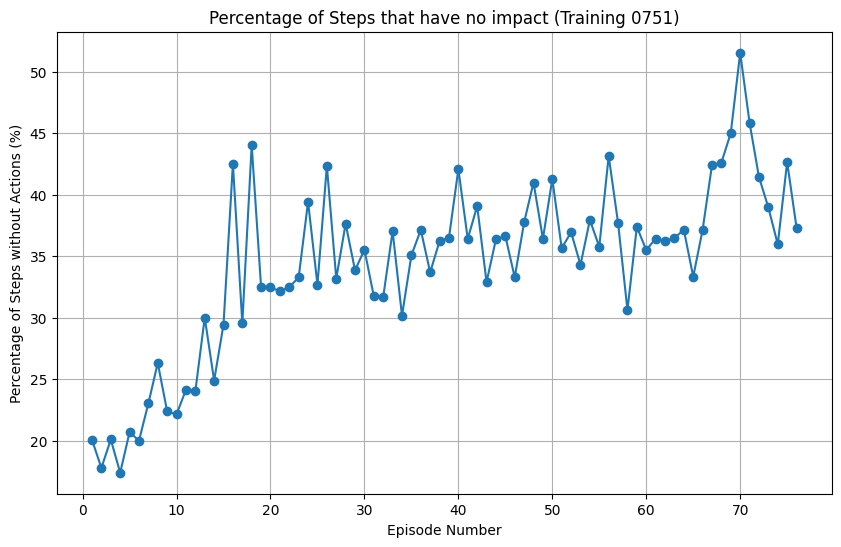

In [1]:
import json
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

latest = True   

if latest:
    # Find the training id with highest id in trainin_{id}.json
    files = glob.glob("../logs/training/training_*.json")
    latest_file = max(files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
    file_path = latest_file
else:
    file_path = "../logs/training/training_0299.json"

# extract the id from the file path
id = file_path.split('_')[-1].split('.')[0]
print(f"Training ID: {id}")

# Load the JSON data from the file
with open(file_path, 'r') as file:
    data = json.load(file)

rewards_total = []
rewards_conflict_resolution = []
rewards_delay = []
rewards_cancelled = []
rewards_inaction = []
rewards_proactive = []
rewards_time_progression = []

total_counter = 0

episode_percentages = []

for episode_number in data['episodes']: 
    episode_data = data['episodes'][episode_number]
    
    # Counter for this episode
    total_steps = 0
    steps_without_action = 0
    
    for scenario_number in episode_data['scenarios']:
        scenario_data = episode_data['scenarios'][scenario_number]
        for step_number in range(len(scenario_data['steps'])):
            step_data = scenario_data['steps'][step_number]
            total_steps += 1
            if 'something_happened' not in step_data['info_after_step'] or step_data['info_after_step']['something_happened'] != 1:
                steps_without_action += 1
    
    # Calculate percentage for this episode
    if total_steps > 0:
        percentage = (steps_without_action / total_steps) * 100
        episode_percentages.append(percentage)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(episode_percentages) + 1), episode_percentages, marker='o')
plt.xlabel('Episode Number')
plt.ylabel('Percentage of Steps without Actions (%)')
plt.title(f'Percentage of Steps that have no impact (Training {id})')
plt.grid(True)
plt.show()


# Reward distribution

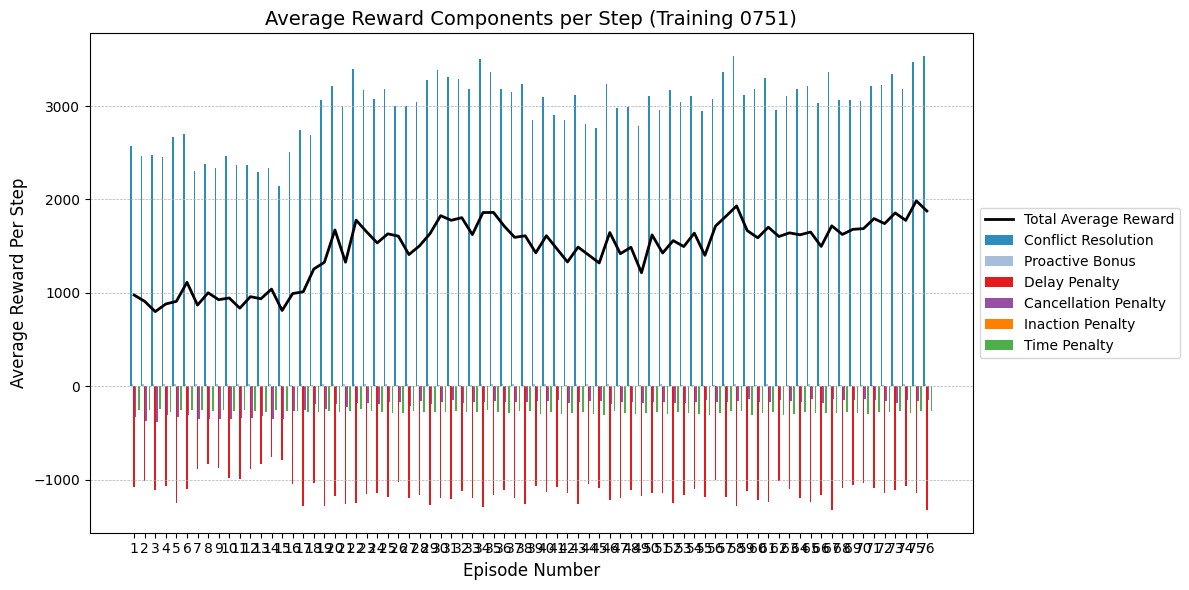

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data to calculate average rewards per step
rewards_total = []
rewards_conflict_resolution = []
rewards_delay = []
rewards_cancelled = []
rewards_inaction = []
rewards_proactive = []
rewards_time_progression = []

for episode_number in data['episodes']:
    episode_data = data['episodes'][episode_number]
    
    # Initialize reward counters for this episode
    total_steps = 0
    episode_total = 0
    episode_conflict = 0
    episode_delay = 0
    episode_cancelled = 0
    episode_inaction = 0
    episode_proactive = 0
    episode_time = 0
    
    for scenario_number in episode_data['scenarios']:
        scenario_data = episode_data['scenarios'][scenario_number]
        steps = len(scenario_data['steps'])  # Total steps in the scenario
        # print(f"Scenario {scenario_number} has {steps} steps")
        total_steps += steps  # Add to total steps
        
        for step_data in scenario_data['steps']:
            info = step_data['info_after_step']
            
            # Sum up the different reward components
            episode_total += step_data['reward']
            episode_conflict += info.get('conflict_resolution_reward', 0)
            episode_delay -= info.get('delay_penalty_total', 0)  # Made negative
            episode_cancelled -= info.get('cancellation_penalty', 0)  # Made negative
            episode_inaction -= info.get('inaction_penalty', 0)  # Made negative
            episode_proactive += info.get('proactive_bonus', 0)
            episode_time -= info.get('time_penalty', 0)  # Made negative
    
    # Calculate average rewards per step
    if total_steps > 0:
        rewards_total.append(episode_total / total_steps)
        rewards_conflict_resolution.append(episode_conflict / total_steps)
        rewards_delay.append(episode_delay / total_steps)
        rewards_cancelled.append(episode_cancelled / total_steps)
        rewards_inaction.append(episode_inaction / total_steps)
        rewards_proactive.append(episode_proactive / total_steps)
        rewards_time_progression.append(episode_time / total_steps)

# Set up the plot
plt.figure(figsize=(12, 6))
x = range(1, len(rewards_total) + 1)

# Professional color palette
colors = ['#2B8CBE', '#A6BDDB', '#E41A1C', '#984EA3', '#FF7F00', '#4DAF4A']

# Create grouped bars
bar_width = 0.15
r1 = np.arange(len(rewards_total))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]

plt.bar(r1, rewards_conflict_resolution, width=bar_width, label='Conflict Resolution', color=colors[0])
plt.bar(r2, rewards_proactive, width=bar_width, label='Proactive Bonus', color=colors[1])
plt.bar(r3, rewards_delay, width=bar_width, label='Delay Penalty', color=colors[2])
plt.bar(r4, rewards_cancelled, width=bar_width, label='Cancellation Penalty', color=colors[3])
plt.bar(r5, rewards_inaction, width=bar_width, label='Inaction Penalty', color=colors[4])
plt.bar(r6, rewards_time_progression, width=bar_width, label='Time Penalty', color=colors[5])

# Plot total rewards as a black line
plt.plot(r3, rewards_total, color='black', label='Total Average Reward', linewidth=2)

# Customize the plot
plt.xlabel('Episode Number', fontsize=12)
plt.ylabel('Average Reward Per Step', fontsize=12)
plt.title(f'Average Reward Components per Step (Training {id})', fontsize=14)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
plt.xticks([r + 2*bar_width for r in range(len(rewards_total))], range(1, len(rewards_total) + 1))

plt.tight_layout()
plt.show()

# # Print values for first episode
# episode_number = 1  
# print(f"\nEpisode {episode_number} Values:")
# print(f"Total Average Reward: {rewards_total[episode_number - 1]:.2f}")
# print(f"Conflict Resolution: {rewards_conflict_resolution[episode_number - 1]:.2f}")
# print(f"Proactive Bonus: {rewards_proactive[episode_number - 1]:.2f}")
# print(f"Delay Penalty: {rewards_delay[episode_number - 1]:.2f}")
# print(f"Cancellation Penalty: {rewards_cancelled[episode_number - 1]:.2f}")
# print(f"Inaction Penalty: {rewards_inaction[episode_number - 1]:.2f}")
# print(f"Time Penalty: {rewards_time_progression[episode_number - 1]:.2f}")



# Available actions for the agent per step

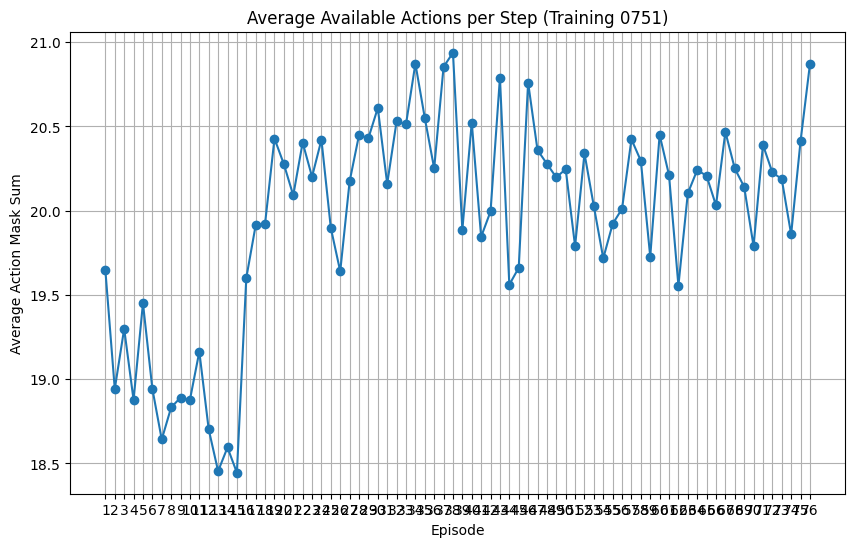

In [3]:

# Initialize variables to store episode-wise sums and counts
episode_action_sums = []
episodes = []

# Process data
for episode_number in data['episodes']:
    episode_data = data['episodes'][episode_number]
    total_action_mask_sum = 0
    step_count = 0

    for scenario_number in episode_data['scenarios']:
        scenario_data = episode_data['scenarios'][scenario_number]

        for step_data in scenario_data['steps']:
            total_action_mask_sum += step_data['action_mask_sum']
            step_count += 1
    
    # Append average for the episode
    if step_count > 0:
        average_action_mask = total_action_mask_sum / step_count
        episode_action_sums.append(average_action_mask)
        episodes.append(episode_number)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(episodes, episode_action_sums, marker='o')
plt.title(f'Average Available Actions per Step (Training {id})')
plt.xlabel('Episode')
plt.ylabel('Average Action Mask Sum')
plt.grid(True)
plt.show()

# Steps to resolve a disrupted scenario

## Total

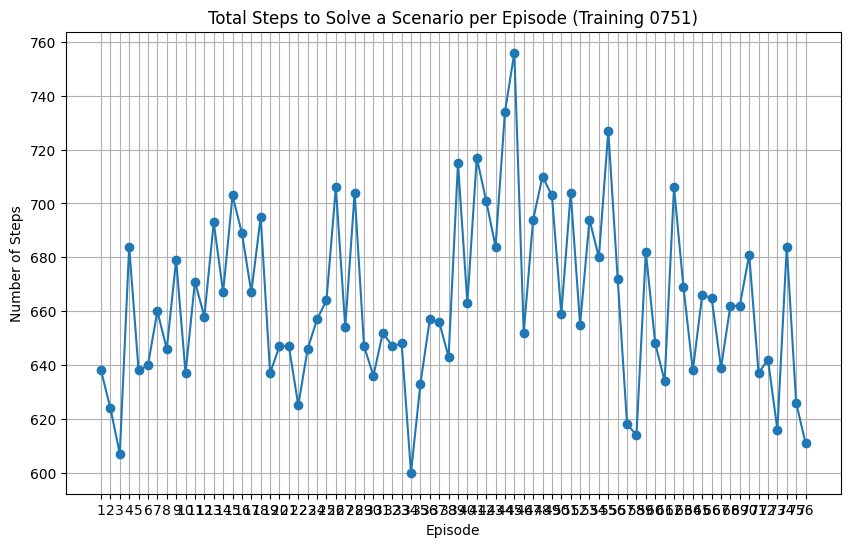

In [4]:
# Initialize variables to store step counts per episode
episode_step_counts = []
episodes = []

# Process data
for episode_number in data['episodes']:
    episode_data = data['episodes'][episode_number]
    total_steps = 0

    for scenario_number in episode_data['scenarios']:
        scenario_data = episode_data['scenarios'][scenario_number]
        total_steps += len(scenario_data['steps'])
    
    episode_step_counts.append(total_steps)
    episodes.append(episode_number)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(episodes, episode_step_counts, marker='o')
plt.title(f'Total Steps to Solve a Scenario per Episode (Training {id})')
plt.xlabel('Episode')
plt.ylabel('Number of Steps')
plt.grid(True)
plt.show()


## Average per scenario

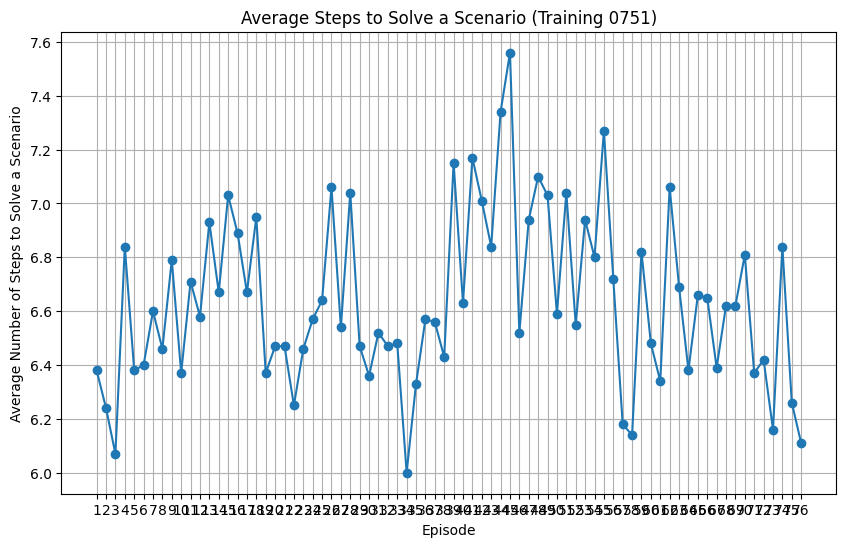

In [5]:
# Initialize variables to store average step counts per episode
episode_avg_step_counts = []
episodes = []

# Process data
for episode_number in data['episodes']:
    episode_data = data['episodes'][episode_number]
    total_steps = 0
    num_scenarios = len(episode_data['scenarios'])

    for scenario_number in episode_data['scenarios']:
        scenario_data = episode_data['scenarios'][scenario_number]
        total_steps += len(scenario_data['steps'])
    
    # Calculate average steps per scenario
    avg_steps = total_steps / num_scenarios if num_scenarios > 0 else 0
    episode_avg_step_counts.append(avg_steps)
    episodes.append(episode_number)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(episodes, episode_avg_step_counts, marker='o')
plt.title(f'Average Steps to Solve a Scenario (Training {id})')
plt.xlabel('Episode')
plt.ylabel('Average Number of Steps to Solve a Scenario')
plt.grid(True)
plt.show()


# Proactive vs. Reactive actions chosen

## Categorized

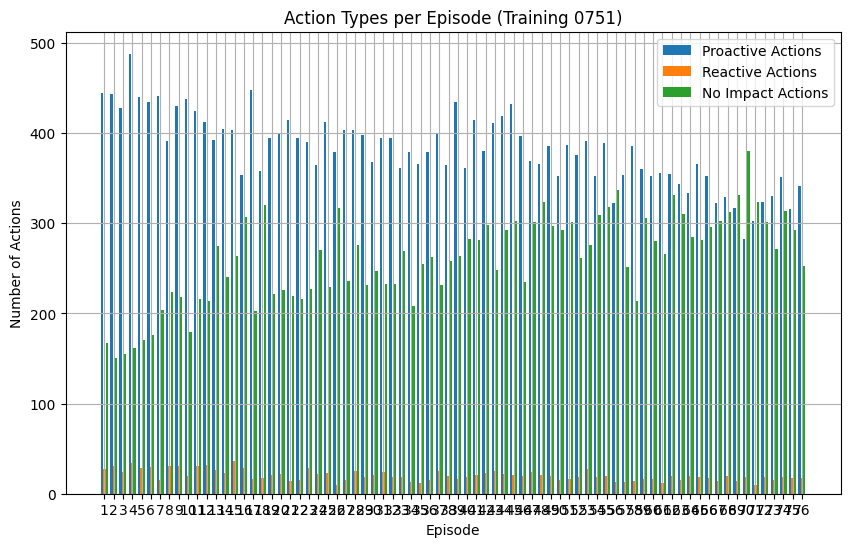

In [6]:
# Set threshold for proactive vs reactive actions (in minutes)
PROACTIVE_THRESHOLD = 30

# Initialize variables to store proactive and reactive counts per episode
episode_proactive_counts = []
episode_reactive_counts = []
episode_no_impact_counts = []
episodes = []

# Process data
for episode_number in data['episodes']:
    episode_data = data['episodes'][episode_number]
    proactive_count = 0
    reactive_count = 0
    no_impact_count = 0

    for scenario_number in episode_data['scenarios']:
        scenario_data = episode_data['scenarios'][scenario_number]
        
        for step in scenario_data['steps']:
            time_to_departure = step['info_after_step'].get('time_to_departure_minutes')
            
            # Handle string values by converting to float if possible
            if isinstance(time_to_departure, str):
                try:
                    time_to_departure = float(time_to_departure)
                except ValueError:
                    time_to_departure = None
            
            if time_to_departure is None:
                no_impact_count += 1
            elif isinstance(time_to_departure, (int, float)) and time_to_departure > PROACTIVE_THRESHOLD:
                proactive_count += 1
            else:
                reactive_count += 1
    
    episode_proactive_counts.append(proactive_count)
    episode_reactive_counts.append(reactive_count)
    episode_no_impact_counts.append(no_impact_count)
    episodes.append(episode_number)

# Create bar plot
plt.figure(figsize=(10, 6))
x = np.arange(len(episodes))
width = 0.25  # Reduced width to fit 3 bars

plt.bar(x - width, episode_proactive_counts, width, label='Proactive Actions')
plt.bar(x, episode_reactive_counts, width, label='Reactive Actions')
plt.bar(x + width, episode_no_impact_counts, width, label='No Impact Actions')

plt.title(f'Action Types per Episode (Training {id})')
plt.xlabel('Episode')
plt.ylabel('Number of Actions')
plt.xticks(x, episodes)
plt.legend()
plt.grid(True)
plt.show()


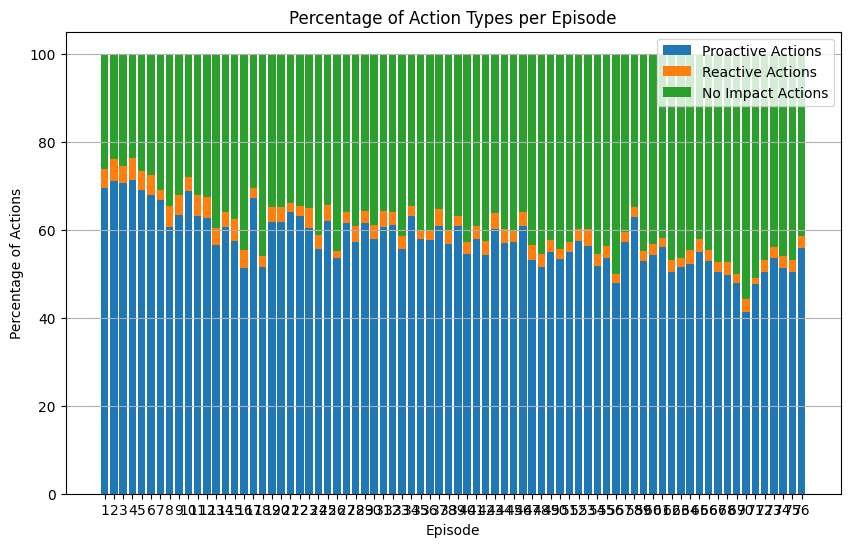

In [7]:
# Calculate total actions per episode
total_actions = (
    np.array(episode_proactive_counts) 
    + np.array(episode_reactive_counts) 
    + np.array(episode_no_impact_counts)
)

# Convert counts to percentages
proactive_percentages = (np.array(episode_proactive_counts) / total_actions) * 100
reactive_percentages = (np.array(episode_reactive_counts) / total_actions) * 100
no_impact_percentages = (np.array(episode_no_impact_counts) / total_actions) * 100

# Create stacked bar plot
plt.figure(figsize=(10, 6))
x = np.arange(len(episodes))

plt.bar(x, proactive_percentages, label='Proactive Actions')
plt.bar(x, reactive_percentages, bottom=proactive_percentages, label='Reactive Actions')
plt.bar(x, no_impact_percentages, 
        bottom=proactive_percentages + reactive_percentages, label='No Impact Actions')

plt.title('Percentage of Action Types per Episode')
plt.xlabel('Episode')
plt.ylabel('Percentage of Actions')
plt.xticks(x, episodes)
plt.legend()
plt.grid(True, axis='y')
plt.show()


## Time ahead of departure for action

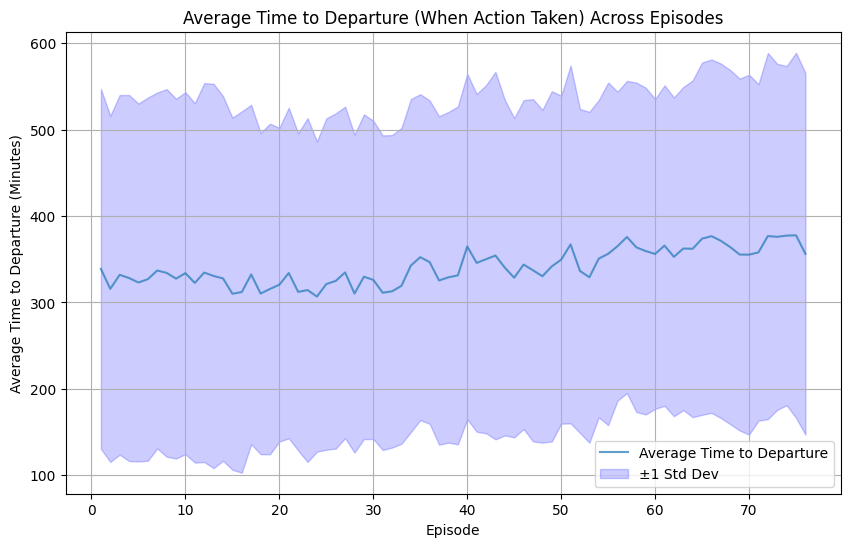

In [8]:
# Initialize lists to store data
episode_avg_time_to_departure = []
episode_std_time_to_departure = []
episodes = []

# Iterate through episodes
for episode_number, episode_data in data['episodes'].items():
    total_time_to_departure = 0
    time_to_departure_values = []
    total_steps_with_action = 0
    
    # Iterate through scenarios in episode
    for scenario_number in episode_data['scenarios']:
        scenario_data = episode_data['scenarios'][scenario_number]
        steps = scenario_data['steps']
        
        # Sum up time to departure for steps where something happened
        for step in steps:
            if step['info_after_step']['something_happened'] == 1:
                # Check if time_to_departure_minutes is not "None" before processing
                ttd = step['info_after_step']['time_to_departure_minutes']
                if isinstance(ttd, (int, float)):  # Only process numeric values
                    time_to_departure_values.append(ttd)
                    total_time_to_departure += ttd
                    total_steps_with_action += 1
    
    # Calculate average time to departure for the episode
    if total_steps_with_action > 0:
        avg_ttd = total_time_to_departure / total_steps_with_action
        std_dev = np.std(time_to_departure_values) if len(time_to_departure_values) > 1 else 0
        episode_avg_time_to_departure.append(avg_ttd)
        episode_std_time_to_departure.append(std_dev)
        episodes.append(int(episode_number))

# Convert lists to numpy arrays for calculations
avg_ttd = np.array(episode_avg_time_to_departure)
std_dev = np.array(episode_std_time_to_departure)

# Create the plot with shaded standard deviation
plt.figure(figsize=(10, 6))
plt.plot(episodes, avg_ttd, alpha=0.7, label='Average Time to Departure')
plt.fill_between(
    episodes, 
    avg_ttd - std_dev, 
    avg_ttd + std_dev, 
    color='blue', 
    alpha=0.2, 
    label='±1 Std Dev'
)
plt.title('Average Time to Departure (When Action Taken) Across Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Time to Departure (Minutes)')
plt.grid(True)
plt.legend()
plt.show()


# Impact of the last step on the total reward

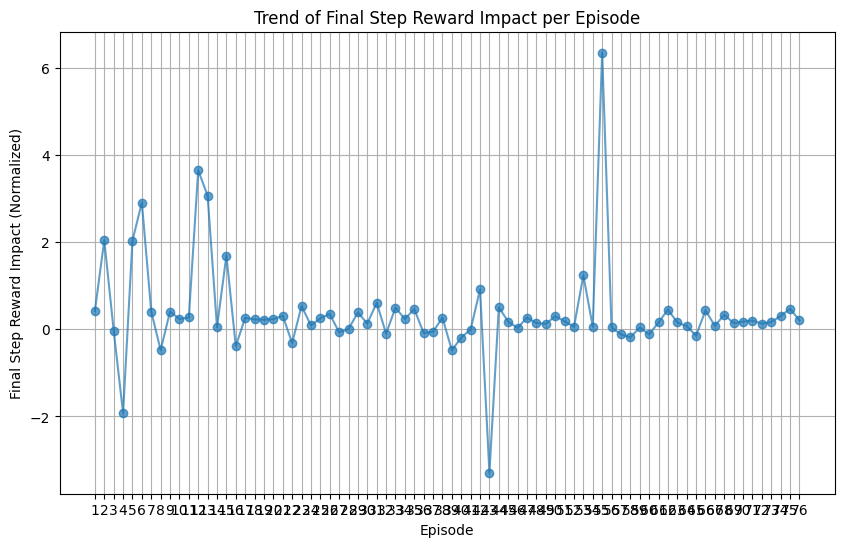

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store data
episode_final_step_impact = []
episodes = []

# Iterate through episodes
for episode_number, episode_data in data['episodes'].items():
    total_final_step_impact = 0
    scenario_count = 0
    
    for scenario_number in episode_data['scenarios']:
        scenario_data = episode_data['scenarios'][scenario_number]
        steps = scenario_data['steps']
        
        if len(steps) > 0:
            # Get total reward from last step
            final_step = steps[-1]
            final_step_reward = final_step['reward']
            
            # Sum up rewards from all steps
            total_reward = sum(step['reward'] for step in steps)
            
            # Calculate normalized contribution of final step to total reward
            if total_reward != 0:  # Avoid division by zero
                final_step_impact = final_step_reward / total_reward
                total_final_step_impact += final_step_impact
                scenario_count += 1
    
    # Calculate average final step impact for the episode
    if scenario_count > 0:
        avg_final_step_impact = total_final_step_impact / scenario_count
        episode_final_step_impact.append(avg_final_step_impact)
        episodes.append(episode_number)
    else:
        episode_final_step_impact.append(0)

# Calculate moving average for smoothing
window_size = 5
moving_avg = np.convolve(episode_final_step_impact, np.ones(window_size)/window_size, mode='valid')

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(episodes, episode_final_step_impact, marker='o', alpha=0.7)
plt.title('Trend of Final Step Reward Impact per Episode')
plt.xlabel('Episode')
plt.ylabel('Final Step Reward Impact (Normalized)')
plt.grid(True)
plt.show()


# Delay length disribution - average per step

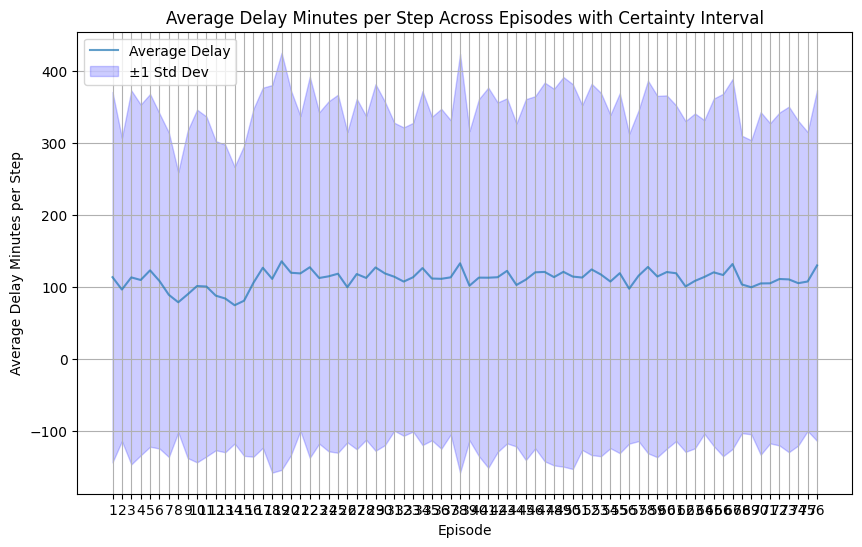

In [10]:
# Initialize lists to store data
episode_avg_delay_minutes = []
episodes = []
episode_std_dev = []  # To store standard deviation for each episode

# Iterate through episodes
for episode_number, episode_data in data['episodes'].items():
    total_delay_minutes = 0
    total_steps = 0
    delay_values = []  # To calculate standard deviation
    
    # Iterate through scenarios in episode
    for scenario_number in episode_data['scenarios']:
        scenario_data = episode_data['scenarios'][scenario_number]
        steps = scenario_data['steps']
        
        # Sum up delay minutes from all steps
        for step in steps:
            delay = step['info_after_step']['delay_penalty_minutes']
            delay_values.append(delay)
            total_delay_minutes += delay
            total_steps += 1
    
    # Calculate average delay minutes for the episode
    if total_steps > 0:
        avg_delay = total_delay_minutes / total_steps
        std_dev = np.std(delay_values)  # Calculate standard deviation
        episode_avg_delay_minutes.append(avg_delay)
        episodes.append(episode_number)
        episode_std_dev.append(std_dev)
    else:
        episode_avg_delay_minutes.append(0)
        episode_std_dev.append(0)

# Convert lists to numpy arrays for calculations
avg_delay = np.array(episode_avg_delay_minutes)
std_dev = np.array(episode_std_dev)

# Create the plot with shaded standard deviation
plt.figure(figsize=(10, 6))
plt.plot(episodes, avg_delay, alpha=0.7, label='Average Delay')
plt.fill_between(
    episodes, 
    avg_delay - std_dev, 
    avg_delay + std_dev, 
    color='blue', 
    alpha=0.2, 
    label='±1 Std Dev'
)
plt.title('Average Delay Minutes per Step Across Episodes with Certainty Interval')
plt.xlabel('Episode')
plt.ylabel('Average Delay Minutes per Step')
plt.grid(True)
plt.legend()
plt.show()


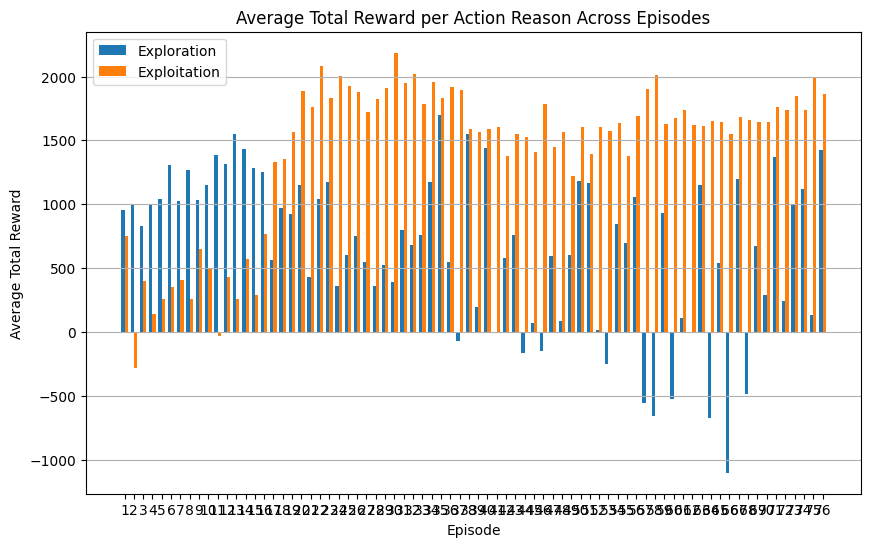

In [11]:
# Initialize lists to store total rewards and action reasons per episode
episode_rewards = []
episode_action_reasons = []

# Iterate through episodes to collect total rewards and action reasons
for episode_number, episode_data in data['episodes'].items():
    total_rewards = []
    action_reasons = []
    
    for scenario_number, scenario_data in episode_data['scenarios'].items():
        steps = scenario_data['steps']
        
        for step in steps:
            total_reward = step['info_after_step']['total_reward']
            action_reason = step['action_reason']  # Assuming this field exists
            
            total_rewards.append(total_reward)
            action_reasons.append(action_reason)

    # Calculate average total reward per action reason for the episode
    reward_exploration = np.mean([reward for reward, reason in zip(total_rewards, action_reasons) if reason == 'exploration']) if total_rewards else 0
    reward_exploitation = np.mean([reward for reward, reason in zip(total_rewards, action_reasons) if reason == 'exploitation']) if total_rewards else 0

    episode_rewards.append((reward_exploration, reward_exploitation))

# Prepare data for plotting
episodes = list(data['episodes'].keys())  # Get episode numbers for x-axis
average_rewards = np.array(episode_rewards)

# Create the bar plot
bar_width = 0.35
x = np.arange(len(episodes))

plt.figure(figsize=(10, 6))
plt.bar(x - bar_width/2, average_rewards[:, 0], width=bar_width, label='Exploration')
plt.bar(x + bar_width/2, average_rewards[:, 1], width=bar_width, label='Exploitation')
plt.title('Average Total Reward per Action Reason Across Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Total Reward')
plt.xticks(x, episodes)
plt.legend()
plt.grid(axis='y')
plt.show()